## **Imports**

In [1]:
USING_COLAB = True
ADD_NEW_FEATURES = True

In [21]:
# Other tools
import pickle
import random
import os

from collections import Counter
from tqdm import tqdm
from copy import deepcopy

# Train
from sklearn.model_selection import KFold, StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Visual
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Preprocessing
import pandas as pd
import numpy as np

from datetime import datetime
from imblearn.over_sampling import SMOTE

# Model
import lightgbm as lgb
import xgboost as xgb

from catboost import CatBoostClassifier, Pool, CatBoostRegressor

import pickle
import sklearn

pd.set_option('display.max_rows', 15)

plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['font.size'] = 18
plt.rcParams['savefig.format'] = 'pdf'

def gini(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

from utils import set_seed_no_torch

In [5]:
SEED = 11
set_seed_no_torch(SEED)

## **Tools for model features analysis**

In [13]:
def select_features_with_shap(model, data, k=100):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(data)

    def print_feature_importances_shap_values(shap_values, features, k, plot=False):

        importances = []
        for i in range(shap_values.values.shape[1]):
            importances.append(np.mean(np.abs(shap_values.values[:, i])))

        # importances_norm =
        sorted_idx = np.argsort(importances)[-k:]
        features_k = features[sorted_idx]


        if plot:
            fig = plt.figure(figsize=(12, 6));
            plt.barh(range(len(features_k)), np.array(importances)[sorted_idx], align='center');
            plt.yticks(range(len(features_k)), features_k);
            plt.title('Feature Importance');
            # fig.figure.savefig(args.save_visual_path + f"{a}_shap_importance.png");

            shap.summary_plot(
                shap_values,
                feature_names=features,
                max_display=15,
                plot_size=(20, 15),
                show=False
            );
            # plt.savefig(args.save_visual_path + f"{args.region}_shap_beeswarm.png", dpi=100);

        return np.array(importances)[sorted_idx], features_k

    _, best_columns_shap = print_feature_importances_shap_values(
        shap_values,
        features=np.array(data.columns),
        k=k,
        plot=True
    )

    return best_columns_shap

In [14]:
def plot_importance(df, best_model, height, top_n=50):

    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков {} Усреднее по {}-ти моделям: '.format(len(cols_ord), len(best_model)) )
    cols_ord = cols_ord[:top_n]

    fi = fi[fi['feature'].isin(cols_ord)]

    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)

    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)

## *Catboost simple*

In [6]:
def load_dfs(names):
    dfs = []
    for name in names:
        with open(f'data/{name}.pickle', 'rb') as f:
            dfs.append(pickle.load(f))
    return dfs

train, test = load_dfs(['train_processed', 'test_processed'])

In [8]:
train, val = sklearn.model_selection.train_test_split(
    train,
    test_size=0.15,
    # stratify=''
)

In [16]:
X_train, y_train = train.drop(columns=['fare_amount', 'pickup_datetime']).drop(columns=[]), train['fare_amount']
X_val, y_val = val.drop(columns=['fare_amount', 'pickup_datetime']), val['fare_amount']

In [59]:
cat_model_params = dict(
    depth=7,
    iterations=3500,
    # learning_rate=0.01,
    # loss_function="MultiClass",
    # loss_function="Logloss"
    loss_function="RMSE",
    # eval_metric="AUC",
    # eval_metric='TotalF1:average=Macro',

    # Регуляризация и ускорение
    colsample_bylevel=0.05,
    subsample=0.9,
    l2_leaf_reg=10,
    # min_data_in_leaf=300,
    # max_bin=300,
    border_count=254,
    # random_strength=1,
    # one_hot_max_size

    # Параметры скорения
    task_type="CPU",
    thread_count=-1,
    bootstrap_type="Bernoulli",

    # boosting_type="Ordered",
    # one_hot_max_size=15,
    # rsm=0.6,
    # cat_features = cat_features,
    # leaf_estimation_iterations=10,
    # max_ctr_complexity=5,

    random_seed=SEED,
    # auto_class_weights="Balanced",
    # scale_pos_weight=8,
    early_stopping_rounds=50,
    use_best_model=True
)

In [60]:
cat_train_pool = Pool(
    data=X_train,
    label=y_train,
)

cat_valid_pool = Pool(
    data=X_val,
    label=y_val,
)

cat_test_pool = Pool(
    data=test.drop(columns=['pickup_datetime'],),
)

In [61]:
cat_clf = CatBoostRegressor(
    **cat_model_params
)

cat_clf.fit(
    cat_train_pool,
    eval_set=[cat_train_pool, cat_valid_pool],
    verbose=50
)

0:	learn: 8.3939500	test: 8.3939500	test1: 8.3354162	best: 8.3354162 (0)	total: 30.7ms	remaining: 1m 47s
50:	learn: 7.1193516	test: 7.1193516	test1: 7.0360953	best: 7.0360953 (50)	total: 2.08s	remaining: 2m 20s
100:	learn: 6.6385746	test: 6.6385746	test1: 6.5481759	best: 6.5481759 (100)	total: 3.69s	remaining: 2m 4s
150:	learn: 6.2462515	test: 6.2462515	test1: 6.1634582	best: 6.1634582 (150)	total: 5.13s	remaining: 1m 53s
200:	learn: 5.8565072	test: 5.8565072	test1: 5.7784566	best: 5.7784566 (200)	total: 6.71s	remaining: 1m 50s
250:	learn: 5.6619586	test: 5.6619586	test1: 5.5889792	best: 5.5889792 (250)	total: 8.39s	remaining: 1m 48s
300:	learn: 5.5073539	test: 5.5073539	test1: 5.4373327	best: 5.4373327 (300)	total: 10.5s	remaining: 1m 51s
350:	learn: 5.4308371	test: 5.4308371	test1: 5.3605787	best: 5.3605787 (350)	total: 11.8s	remaining: 1m 45s
400:	learn: 5.2627102	test: 5.2627102	test1: 5.1949578	best: 5.1949578 (400)	total: 13.9s	remaining: 1m 47s
450:	learn: 5.1213894	test: 5.1213

In [62]:
final_preds = cat_clf.predict(
    cat_test_pool
)

In [63]:
sub = pd.concat(
    [
        pd.read_csv('test (1).csv')['key'],
        pd.Series(final_preds).rename('fare_amount'),
    ],
    axis=1
)

In [64]:
sub.to_csv('taxi_sub_third.csv', index=False)

## **Run CatBoost Cross-val**

In [10]:
import sklearn
cat_models = []
cat_aucs = []

cat_model_params = dict(
    depth=8,
    iterations=3500,
    # learning_rate=0.01,
    # loss_function="MultiClass",
    loss_function="Logloss",
    eval_metric="AUC",
    # eval_metric='TotalF1:average=Macro',

    # Регуляризация и ускорение
    colsample_bylevel=0.05,
    subsample=0.9,
    l2_leaf_reg=10,
    # min_data_in_leaf=300,
    # max_bin=300,
    border_count=254,
    # random_strength=1,
    # one_hot_max_size

    # Параметры скорения
    task_type="CPU",
    thread_count=-1,
    bootstrap_type="Bernoulli",

    # boosting_type="Ordered",
    # one_hot_max_size=15,
    # rsm=0.6,
    # cat_features = cat_features,
    # leaf_estimation_iterations=10,
    # max_ctr_complexity=5,

    random_seed=SEED,
    auto_class_weights="Balanced",
    # scale_pos_weight=8,
    early_stopping_rounds=50,
    use_best_model=True
)


print("TRAINING CATBOOST")
for fold in range(0, 5):

    cur_train = pickle.load('')
    cur_val= pickle.load('')

    X_train, X_valid, y_train, y_valid = deepcopy(cur_train.drop("", axis=1)), \
                                         deepcopy(cur_val.drop("", axis=1)), \
                                         deepcopy(cur_train[""]), \
                                         deepcopy(cur_val[""])

    print(f"{'*' * 20}\nFOLD {fold}\ncur train shape: {X_train.shape}\ncur val shape: {X_valid.shape}\n{'-' * 20}")


    cat_train_pool = Pool(
        data=X_train,
        label=y_train,
    )

    cat_valid_pool = Pool(
        data=X_valid,
        label=y_valid,
      
    )

    cat_clf = CatBoostClassifier(
        **cat_model_params
    )

    cat_clf.fit(
        cat_train_pool,
        eval_set=[cat_train_pool, cat_valid_pool],
        verbose=50
    )

    cat_y_pred = cat_clf.predict_proba(
        cat_valid_pool
    )[:, 1]

    cat_models.append(cat_clf)
    cat_aucs.append(sklearn.metrics.roc_auc_score(y_valid, cat_y_pred))

    print(f"\n{'-' * 20}\nFOLD {fold} RESULTS:")
    print(f"catboost score: {cat_aucs[-1]}")
    print(f"{'*' * 20}\n\n\n\n")

TRAINING CATBOOST


AttributeError: module 'pickle' has no attribute 'open'

In [ ]:
cat_preds = []

for fold, cat_model in enumerate(cat_models):

  cat_p = cat_model.predict_proba(cat_test_pool)
  cat_preds.append(cat_p)

w = cat_aucs
final_preds = np.sum([w_i * f_p for w_i, f_p in zip(w, cat_preds)], axis=0) / np.sum(w)

### анализ модели

## **Run LGBM cross-val**

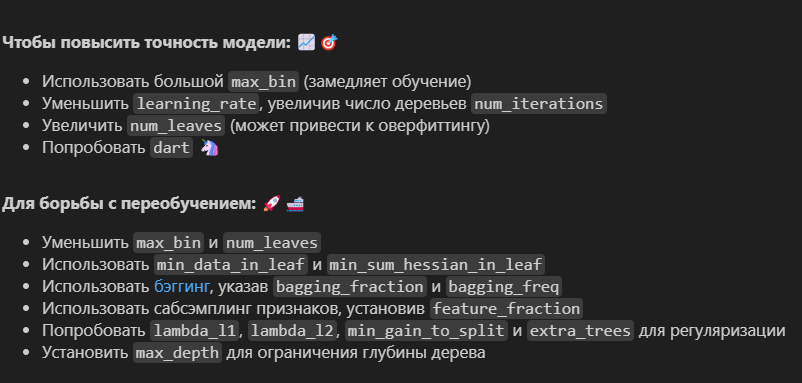

In [ ]:
lgbm_aucs = []
lgbm_models = []

lgbm_model_params = {

        # основное
        'boosting_type': 'dart',
        'drop_rate' : 0.8,
        'skip_drop' : 0.1,
        'xgboost_dart_mode' : True,
        'uniform_drop' : True,
        'num_leaves': 50,

        #дефолт
        'metric' : 'auc',
        'objective': 'binary',
        'learning_rate': 0.05,
        # 'scale_pos_weight' : 7.5,
        'force_col_wise' : True,
        'is_unbalance' : True,


        #регуляризация деревьев
        'max_depth' : -1,
        'min_data_in_leaf' : 100,
        'bagging_fraction' : 0.05,
        'feature_fraction' : 0.9,
        'extra_trees' : False,

        # точность
        'max_bin' : 255,

    }

kf = StratifiedGroupKFold(n_splits=5, random_state=SEED, shuffle=True)

print("TRAINING LGBM")
for fold in range(5):

    

    print(f"{'*' * 20}\nFOLD {fold}\ncur train shape: {cur_train.shape}\ncur val shape: {cur_val.shape}\n{'-' * 20}")


    X_train, X_valid, y_train, y_valid = cur_train.drop("default6", axis=1), \
                                         cur_val.drop("default6", axis=1), \
                                         cur_train["default6"], \
                                         cur_val["default6"]

    X_train.drop("contract_id", axis=1, inplace=True)
    X_valid.drop("contract_id", axis=1, inplace=True)

    X_train = X_train.sample(frac=1)
    y_train = y_train.loc[X_train.index]
    X_train = X_train.reset_index(drop=True)


    lgbm_train_data = lgb.Dataset(
        data=X_train,
        label=y_train,
        categorical_feature=cat_features,
    )

    lgbm_test_data = lgb.Dataset(
        data=X_valid,
        label=y_valid,
        reference=lgbm_train_data,
        categorical_feature=cat_features,
    )

    lgbm_clf = lgb.train(
        lgbm_model_params,
        lgbm_train_data,
        num_boost_round=1000,
        valid_sets=[lgbm_train_data, lgbm_test_data],
        valid_names=["train", "validation"],
        callbacks=[
            lgb.early_stopping(
                stopping_rounds=50,
                min_delta=0.001
            ),
            lgb.log_evaluation(period=20)
        ]
    )

    # y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration) > 0.5
    lgbm_y_pred = lgbm_clf.predict(
        X_valid,
        num_iteration=lgbm_clf.best_iteration,
        # raw_score=True
    )
    # score = (y_pred == y_valid).mean()

    lgbm_models.append(lgbm_clf)
    lgbm_aucs.append(roc_auc_score(y_valid, lgbm_y_pred))

    print(f"{'*' * 20}\nFOLD {fold} RESULTS:")
    print(f"lgbm score: {lgbm_aucs[-1]}")
    print(f"{'-' * 20}\n\n\n\n")

TRAINING LGBM
********************
FOLD 0
cur train shape: (24032, 169)
cur val shape: (4799, 169)
--------------------
[LightGBM] [Info] Number of positive: 3924, number of negative: 20108
[LightGBM] [Info] Total Bins 25523
[LightGBM] [Info] Number of data points in the train set: 24032, number of used features: 166
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.163282 -> initscore=-1.634006
[LightGBM] [Info] Start training from score -1.634006


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[20]	train's auc: 0.964382	validation's auc: 0.718503
[40]	train's auc: 0.973969	validation's auc: 0.746855
[60]	train's auc: 0.974265	validation's auc: 0.747375
[80]	train's auc: 0.980224	validation's auc: 0.75178
[100]	train's auc: 0.983761	validation's auc: 0.752877


KeyboardInterrupt: 

In [ ]:
lgbm_aucs = [s * w for s, w in zip(lgbm_aucs, [0.05, 0.15, 0.2, 0.25, 0.35])]

lgbm_dict["params"].append(lgbm_model_params)
lgbm_dict["used_features"].append(new_train_.columns)
lgbm_dict["score"].append(np.sum(lgbm_aucs))

pd.DataFrame.from_dict(lgbm_dict).to_csv("lgbm_experiments_new_val.csv", index=False)

print(f"CV LGBM RESULTS score={lgbm_dict['score'][-1]:.3f}")

NameError: name 'lgbm_dict' is not defined

## **Run Xgboost cross-val**

In [ ]:
xgb_models = []
xgb_aucs = []

xgb_model_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': 0.05,
        'max_depth': 9,
        'subsample': 0.95,
        'colsample_bytree': 0.1,
        'seed': SEED,
        'verbosity':0,
        'scale_pos_weight' : 7.5,
    }

kf = StratifiedGroupKFold(n_splits=5, random_state=SEED, shuffle=True)

print("TRAINING XGBOOST")
for fold, (train_index, test_index) in enumerate(
          kf.split(
              X=train_no_corr.drop("default6", axis=1),
              y=train_no_corr["default6"],
              groups=train_no_corr["contract_id"])
        ):

    print(f"{'*' * 20}\nFOLD {fold}\n{'-' * 20}")

    X_train, X_valid, y_train, y_valid = train_no_corr.iloc[train_index].drop("default6", axis=1), \
                                         train_no_corr.iloc[test_index].drop("default6", axis=1), \
                                         train_no_corr.iloc[train_index]["default6"], \
                                         train_no_corr.iloc[test_index]["default6"]

    X_train.drop("contract_id", axis=1, inplace=True)
    X_valid.drop("contract_id", axis=1, inplace=True)

    for cat_feature in cat_features:
      X_train[cat_feature] = X_train[cat_feature].astype("category")
      X_valid[cat_feature] = X_valid[cat_feature].astype("category")

    xgb_train_data = xgb.DMatrix(
        data=X_train,
        label=y_train,
        enable_categorical=True
    )

    xgb_test_data = xgb.DMatrix(
        data=X_valid,
        label=y_valid,
        enable_categorical=True
    )

    evals = [(xgb_test_data, 'eval'), (xgb_train_data, 'train')]
    xgb_clf = xgb.train(
        xgb_model_params,
        dtrain=xgb_train_data,
        num_boost_round=1000,
        evals=evals,
        early_stopping_rounds=100,
        verbose_eval=False
    )
    xgb_y_pred = xgb_clf.predict(xgb_test_data)
    # score = (y_pred > y_valid).mean()

    xgb_models.append(xgb_clf)
    xgb_aucs.append(roc_auc_score(y_valid, xgb_y_pred))

    print(f"{'*' * 20}\nFOLD {fold} RESULTS:")
    print(f"xgb score: {xgb_aucs[-1]}")
    print(f"{'-' * 20}\n\n\n\n")

TRAINING XGBOOST
********************
FOLD 0
--------------------
********************
FOLD 0 RESULTS:
xgb score: 0.7729077551492635
--------------------




********************
FOLD 1
--------------------
********************
FOLD 1 RESULTS:
xgb score: 0.7783434417968469
--------------------




********************
FOLD 2
--------------------
********************
FOLD 2 RESULTS:
xgb score: 0.8150940583234494
--------------------




********************
FOLD 3
--------------------
********************
FOLD 3 RESULTS:
xgb score: 0.7588544367049136
--------------------




********************
FOLD 4
--------------------
********************
FOLD 4 RESULTS:
xgb score: 0.7664817939280046
--------------------






In [ ]:
xgb_aucs = [s * w for s, w in zip(xgb_aucs, [0.05, 0.15, 0.2, 0.25, 0.35])]

xgb_dict["params"].append(xgb_model_params)
xgb_dict["used_features"].append(train_no_corr.columns)
# xgb_dict["score"].append(np.mean(xgb_aucs) - np.std(xgb_aucs))
xgb_dict["score"].append(np.sum(xgb_aucs))

pd.DataFrame.from_dict(xgb_dict).to_csv("xgb_experiments_new_val.csv", index=False)

print(f"CV XGB RESULTS score={xgb_dict['score'][-1]:.3f}")

CV XGB RESULTS score=0.759


## **All boostings cross-val one-time**

In [ ]:
xgb_models = []
cat_models = []
lgbm_models = []

xgb_aucs = []
cat_aucs = []
lgbm_aucs = []
cat_xgb_aucs = []
lgbm_xgb_aucs = []
cat_lgbm_aucs = []
cat_lgbm_xgb_aucs = []


kf = StratifiedGroupKFold(n_splits=5, )
for fold, (train_index, test_index) in enumerate(
          kf.split(
              X=train_no_corr.drop("default6", axis=1),
              y=train_no_corr["default6"],
              groups=train_no_corr["contract_id"])
        ):

    print(f"{'*' * 20}\nFOLD {fold}\n{'-' * 20}")

    X_train, X_valid, y_train, y_valid = train_no_corr.iloc[train_index].drop("default6", axis=1), \
                                         train_no_corr.iloc[test_index].drop("default6", axis=1), \
                                         train_no_corr.iloc[train_index]["default6"], \
                                         train_no_corr.iloc[test_index]["default6"]

    X_train.drop("contract_id", axis=1, inplace=True)
    X_valid.drop("contract_id", axis=1, inplace=True)

    # if i < 3:
    # CATBOOSTS
    print("TRAINING CATBOOST")
    cat_train_pool = Pool(
        data=X_train,
        label=y_train,
        cat_features=cat_features
    )

    cat_valid_pool = Pool(
        data=X_valid,
        label=y_valid,
        cat_features=cat_features
    )

    cat_clf = CatBoostClassifier(
        depth=8,
        iterations=3500,
        learning_rate=0.01,
        loss_function="LogLoss",
        eval_metric=["AUC"],

        cat_features=cat_features,

        # Регуляризация и ускорение
        colsample_bylevel=0.098,
        subsample=0.95,
        l2_leaf_reg=10,
        min_data_in_leaf=187,
        max_bin=300,
        random_strength=1,
        # one_hot_max_size

        # Параметры скорения
        task_type="CPU",
        thread_count=-1,
        bootstrap_type="Bernoulli",

        boosting_type="Ordered",
        one_hot_max_size=20,
        rsm=0.6,
        # cat_features = cat_features,
        leaf_estimation_iterations=10,
        max_ctr_complexity=3,

        random_seed=SEED,
        auto_class_weights="SqrtBalanced",
        early_stopping_rounds=50,
        use_best_model=True
    )

    cat_clf.fit(
        cat_train_pool,
        eval_set=cat_valid_pool,
        verbose=False
    )

    cat_y_pred = cat_clf.predict_proba(
        X=cat_valid_pool
    )[:, 1]

    cat_models.append(cat_clf)
    cat_aucs.append(roc_auc_score(y_valid, cat_y_pred))











    # elif i == 3:
    # LGBM
    print("TRAINING LGBM")

    lgbm_train_data = lgb.Dataset(
        data=X_train,
        label=y_train,
        categorical_feature=cat_features,
    )

    lgbm_test_data = lgb.Dataset(
        data=X_valid,
        label=y_valid,
        reference=lgbm_train_data,
        categorical_feature=cat_features,
    )

    lgbm_params = {
        'objective': 'binary',
        # 'metric': 'binary_error',
        'boosting_type': 'gbdt',
        'num_leaves': 50,
        'learning_rate': 0.05,
        'feature_fraction': 0.9 ,
        'scale_pos_weight' : 7.5,
        'metric' : 'auc'
    }

    lgbm_clf = lgb.train(
        lgbm_params,
        lgbm_train_data,
        num_boost_round=1000,
        valid_sets=[lgbm_test_data],
        valid_names=["validation"],
        callbacks=[
            lgb.early_stopping(
                stopping_rounds=50,
                min_delta=0.001
            ),
            lgb.log_evaluation(period=-1)
        ]
    )

    # y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration) > 0.5
    lgbm_y_pred = lgbm_clf.predict(
        X_valid,
        num_iteration=lgbm_clf.best_iteration,
        # raw_score=True
    )
    # score = (y_pred == y_valid).mean()

    lgbm_models.append(lgbm_clf)
    lgbm_aucs.append(roc_auc_score(y_valid, lgbm_y_pred))








    #else:

    # XGB
    print("TRAINING XGB")

    for cat_feature in cat_features:
      X_train[cat_feature] = X_train[cat_feature].astype("category")
      X_valid[cat_feature] = X_valid[cat_feature].astype("category")


    xgb_train_data = xgb.DMatrix(
        data=X_train,
        label=y_train,
        enable_categorical=True
    )

    xgb_test_data = xgb.DMatrix(
        data=X_valid,
        label=y_valid,
        enable_categorical=True
    )

    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': 0.05,
        'max_depth': 9,
        'subsample': 0.95,
        'colsample_bytree': 0.1,
        'seed': SEED,
        'verbosity':0,
        'scale_pos_weight' : 7.5,
    }

    evals = [(xgb_test_data, 'eval'), (xgb_train_data, 'train')]
    xgb_clf = xgb.train(
        xgb_params,
        dtrain=xgb_train_data,
        num_boost_round=1000,
        evals=evals,
        early_stopping_rounds=100,
        verbose_eval=False
    )
    xgb_y_pred = xgb_clf.predict(xgb_test_data)
    # score = (y_pred > y_valid).mean()

    xgb_models.append(xgb_clf)
    xgb_aucs.append(roc_auc_score(y_valid, xgb_y_pred))



    # Calculating val results
    cat_score = cat_aucs[-1]
    lgbm_score = lgbm_aucs[-1]
    xgb_score = xgb_aucs[-1]

    cat_xgb_score = roc_auc_score(
        y_valid,
        (cat_y_pred * cat_score + xgb_y_pred * xgb_score) / (xgb_score + cat_score)
    )

    cat_lgbm_score = roc_auc_score(
        y_valid,
        (cat_y_pred * cat_score + lgbm_y_pred * lgbm_score) / (lgbm_score + cat_score)
    )

    lgbm_xgb_score = roc_auc_score(
        y_valid,
        (lgbm_y_pred * lgbm_score + xgb_y_pred * xgb_score) / (xgb_score + lgbm_score)
    )

    cat_lgbm_xgb_score = roc_auc_score(
        y_valid,
        (cat_y_pred * cat_score + xgb_y_pred * xgb_score + lgbm_y_pred * lgbm_score) / (xgb_score + cat_score + lgbm_score)
    )

    cat_xgb_aucs.append(cat_xgb_score)
    lgbm_xgb_aucs.append(lgbm_xgb_score)
    cat_lgbm_aucs.append(cat_lgbm_score)
    cat_lgbm_xgb_aucs.append(cat_lgbm_xgb_score)

    print(f"{'*' * 20}\nFOLD {fold} RESULTS:")
    print(f"catboost score: {cat_score}")
    print(f"lgbm score: {lgbm_score}")
    print(f"xgb score: {cat_score}")
    print(f"cat+lgbm score: {cat_lgbm_score}")
    print(f"lgbm+xgb score: {lgbm_xgb_score}")
    print(f"cat+xgb score: {cat_xgb_score}")
    print(f"cat+lgbm+xgb score: {cat_lgbm_xgb_score}")
    print(f"{'-' * 20}\n\n\n\n")


********************
FOLD 0
--------------------
TRAINING CATBOOST
TRAINING LGBM
[LightGBM] [Info] Number of positive: 3768, number of negative: 19304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.477412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50315
[LightGBM] [Info] Number of data points in the train set: 23072, number of used features: 1334
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.163315 -> initscore=-1.633768
[LightGBM] [Info] Start training from score -1.633768
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[164]	validation's auc: 0.762278
TRAINING XGB
********************
FOLD 0 RESULTS:
catboost score: 0.7469602341699584
lgbm score: 0.7622776856267423
xgb score: 0.7469602341699584
cat+lgbm score: 0.7681015867699468
lgbm+xgb score: 0.7681918549117388
cat+xgb score: 0.7685974523782941
cat+lgbm+xgb score: 0.7714051792426248
-----

In [ ]:
print("CATBOOST MEAN VAL: ", np.mean(cat_aucs))
print("XGBOOST MEAN VAL: ", np.mean(xgb_aucs))
print("LGBM MEAN VAL: ", np.mean(lgbm_aucs))
print("CATBOOST+XGB+LGBM MEAN VAL: ", np.mean(cat_lgbm_xgb_aucs))
print("CATBOOST+LGBM MEAN VAL: ", np.mean(cat_lgbm_aucs))
print("XGB+LGBM MEAN VAL: ", np.mean(lgbm_xgb_aucs))
print("CATBOOST+XGB MEAN VAL: ", np.mean(cat_xgb_aucs))

CATBOOST MEAN VAL:  0.7651058622788022
XGBOOST MEAN VAL:  0.7834701740370994
LGBM MEAN VAL:  0.7870550462137056
CATBOOST+XGB+LGBM MEAN VAL:  0.7894740133233451
CATBOOST+LGBM MEAN VAL:  0.7877869549522376
XGB+LGBM MEAN VAL:  0.7898668105848325
CATBOOST+XGB MEAN VAL:  0.7823310193956912


## **Inference**

### *CatBoost new pipeline inference*

### making submit

<Axes: xlabel='score', ylabel='Count'>

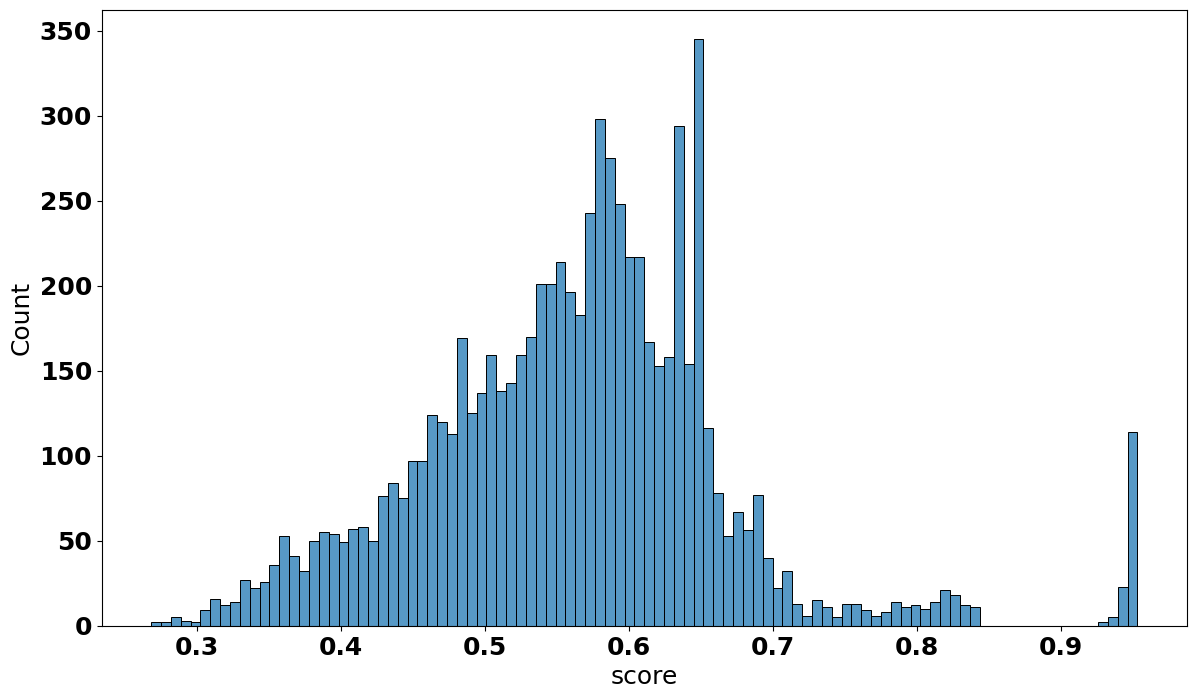

In [ ]:
sns.histplot(
    sample_submit["score"],
    bins=100
)

In [ ]:
if USING_COLAB:
  subs_path = "/content/subs"
else:
  subs_path = "subs"

if not os.path.exists(subs_path):
  os.mkdir(subs_path)

# sub_name = "all_folds_default_catboost_w_feature_selection"
# sub_name = "default_catboost_with_weights_fixed_blended_new"
sub_name = "catboost_almost_no_overfit"
sample_submit.to_csv(f"{subs_path}/{sub_name}.csv", index=False)